# Лабораторная работа 4. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Эта лабораторная работа про задачу из соревнования

https://contest.yandex.ru/contest/36927/problems/


**(1 балла) Задание 1.** Знакомство с данными.

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- users), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


In [1]:
%load_ext nb_black

import abc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from functools import partial, reduce

<IPython.core.display.Javascript object>

In [2]:
def read_ints(line):
    return list(map(int, line.split()))


def read_data(
    path="data/*.csv",
    converters={"rubrics_id": read_ints, "features_id": read_ints},
    index_col=0,
):
    data = {}
    for csv_filename in glob.glob(path):
        basename, extension = os.path.splitext(os.path.basename(csv_filename))
        data[basename] = pd.read_csv(
            csv_filename,
            converters=converters,
            index_col=index_col,
        )
    return data

<IPython.core.display.Javascript object>

In [3]:
data = read_data()
users = data["users"]
organisations = data["organisations"]
reviews = data["reviews"].reset_index()

/external2/dkkoshman/venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/external2/dkkoshman/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<IPython.core.display.Javascript object>

* Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.

In [4]:
def describe_review_counts(
    df,
    reviews,
    axis,
    title,
    quantiles=(0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999, 0.9999, 1),
    quantiles_to_plot=(0.5, 0.99, 0.999, 0.9999),
    plt_kwargs=None,
    cmap="hsv",
):
    reviews_count = reviews.groupby(df.index.name).size().reindex(df.index)
    reviews_count.plot(ax=axis, title=title, **(plt_kwargs or {}))
    axis.set_xlabel(plt_kwargs.get("xlabel"))
    axis.set_ylabel(plt_kwargs.get("ylabel"))

    for i, q in enumerate(quantiles_to_plot, start=1):
        quantile = reviews_count.quantile(q=q)
        axis.axvline(quantile, ls="--", c=plt.get_cmap(name=cmap)(q))
        axis.text(quantile, axis.get_ylim()[1] / 2**i, f"{100*q}%", ha="left")

    return reviews_count.agg(
        {
            "mean": pd.Series.mean,
            "std": pd.Series.std,
            **{f"{100*q}%": partial(pd.Series.quantile, q=q) for q in quantiles},
        }
    )


def show_review_counts(users, organisations, reviews):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    plt_kwargs = dict(
        kind="hist",
        log=True,
        histtype="stepfilled",
        bins=100,
        edgecolor="black",
        facecolor="gray",
        alpha=0.5,
        xlabel="Reviews count",
        ylabel="Frequency (log scale)",
    )
    return pd.DataFrame(
        {
            title: describe_review_counts(
                df,
                reviews,
                axis,
                title=title,
                plt_kwargs=plt_kwargs,
            )
            for df, axis, title in zip(
                [users, organisations],
                axes,
                ["Users reviews written", "Organisations reviews received"],
            )
        }
    ).T

<IPython.core.display.Javascript object>

,mean,std,0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,99.9%,99.99%,100%
Users reviews written,2.964589,4.854616,1.0,1.0,1.0,3.0,6.0,10.0,22.0,54.000,117.0000,611.0
Organisations reviews received,60.429564,436.475347,1.0,2.0,8.0,32.0,125.0,246.0,785.0,3021.324,15019.8882,61520.0


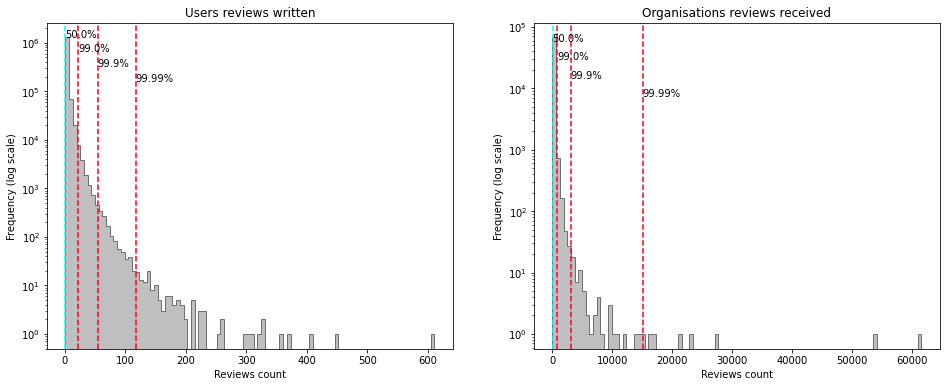

<IPython.core.display.Javascript object>

In [5]:
show_review_counts(users, organisations, reviews)

* Предложите стратегии фильтрации данных.

Отбросить организации, у которых мало оценок и все они негативные. Это наименее полезные для нас организации, поскольку они одновременно не дают много информации о взаимных интересах пользователей, и не пригодятся для конечных рекомендаций.

Реализация этой стратегии может выглядеть так: мы сортируем организации по значению функции полезности

$$f(\text{organisation}) = (\text{rating count})(1 + \text{rating std})^\alpha (\text{mean rating})^\beta$$

И отсекаем $\gamma$ первых организаций, где $\alpha, \beta$ и $\gamma$ подбираются по нашим предпочтениям.

* Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics. Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?

Эти таблицы содержат текстовые описания, так что можно взять их эмбединги или обучить латентные векторные представления, либо кластеризовать и взять метки кластеров, и использовать все это в качестве дополнительных признаков.

---

**(1 балла) Задание 2.** Организация валидации.

Как вы помните, обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

Следовательно нам необходимо организовать у себя валидацию схожим образом.
Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времени на 3 группы train validation и holdout.

Как уже говорилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делать не будем, но для конкурса имейте это в виду.


In [7]:
def split_by_column(df, sizes, column_name, debug=False):
    cumulative_sizes = np.cumsum([0] + sizes)
    total_size = len(df) // 100 if debug else len(df)
    split_edges = [int(s * total_size) for s in cumulative_sizes]
    sorted_df = df.sort_values(column_name)
    splits = [sorted_df[b:e] for b, e in zip(split_edges, split_edges[1:])]
    return splits

<IPython.core.display.Javascript object>

In [8]:
train_reviews, validation_reviews, holdout_reviews = split_by_column(
    reviews, sizes=[0.7, 0.15, 0.15], column_name="ts", debug=True
)

<IPython.core.display.Javascript object>

**(0.5 балла) Задание 3.** Базовые решения.

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

In [9]:
class BaseRecommender(abc.ABC):
    @abc.abstractmethod
    def fit(self, reviews):
        return self

    @abc.abstractmethod
    def recommend(self, user_ids, recommend_size=20):
        return recommendations


class RandomRecommender(BaseRecommender):
    def __init__(self, users, organisations):
        self.users = users
        self.organisations = organisations

    def fit(self, reviews):
        return self

    def recommend(self, user_ids, recommend_size=20):
        recommendations = np.random.choice(
            self.organisations.index, size=(len(user_ids), recommend_size)
        )
        return pd.DataFrame(recommendations, user_ids)


class PopularRecommender(BaseRecommender):
    def __init__(self, users, organisations):
        self.users = users
        self.organisations = organisations

    def fit(self, reviews):
        self.popular_foreign_organisations_for_home_city = {}
        organisations = self.organisations.join(
            reviews.groupby("org_id").size().rename("popularity")
        )
        for city in organisations["city"].unique():
            self.popular_foreign_organisations_for_home_city[city] = (
                organisations.query("city != @city")
                .sort_values("popularity", ascending=False)
                .index.to_numpy()
            )
        return self

    def recommend(self, user_ids, recommend_size=20):
        recommendations = np.stack(
            self.users.loc[user_ids]["city"]
            .map(
                lambda city: self.popular_foreign_organisations_for_home_city[city][
                    :recommend_size
                ]
            )
            .values
        )
        return pd.DataFrame(recommendations, user_ids)

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 4.** Метрики качества.

Напомним, что у нас бинарная релевантнотсь на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние паекты):

    * MNAP@20 (как в описании соревнования)
    * HitRate ( = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
    * MRR@20 ( обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
    * Coverage (доля item-ов, учитываемых в рекомендациях)
    * Surprisal(см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

In [10]:
class MetricsBase:
    def __init__(self, users, organisations, reviews, k=20):
        self.users = users
        self.organisations = organisations
        self.reviews = reviews
        self.k = k
        self.relevant_orgs_for_users = (
            reviews.query("rating >= 4")
            .groupby("user_id")["org_id"]
            .apply(np.array)
            .rename("relevant_org_ids")
        )
        self.recommendations = None
        self.relevance = None

    def binary_relevance(self, recommendations):
        relevance = (
            pd.merge(
                recommendations.agg(np.array, axis="columns").rename(
                    "predicted_org_ids"
                ),
                self.relevant_orgs_for_users,
                left_index=True,
                right_index=True,
                how="left",
            )
            .aggregate(
                lambda row: np.isin(row["predicted_org_ids"], row["relevant_org_ids"]),
                axis="columns",
            )
            .pipe(
                lambda series: pd.DataFrame(np.stack(series.values), index=series.index)
            )
        )
        return relevance

    def precalculate_relevance(self, recommendations):
        self.recommendations = recommendations
        self.relevance = self.binary_relevance(recommendations.iloc[:, : self.k])

    @staticmethod
    def wrap_metric(metric):
        """Precalculate relevance if recommendations were passed."""

        def wrapper(self, recommendations=None, **kwargs):
            if recommendations is not None:
                self.precalculate_relevance(recommendations)
            elif self.recommendations is None:
                raise ValueError(
                    "recommendations must be passed when first calculating a metric."
                )
            return metric(self, **kwargs)

        return wrapper

    def __init_subclass__(cls):
        """Wrap all subclass attributes"""
        super().__init_subclass__()
        for child_attribute in cls.__dict__.keys() - MetricsBase.__dict__.keys():
            setattr(
                cls,
                child_attribute,
                MetricsBase.wrap_metric(object.__getattribute__(cls, child_attribute)),
            )


class Metrics(MetricsBase):
    def precision(self):
        precision = self.relevance.astype(int).expanding(axis="columns").mean()
        return precision

    def ideal_precision(self):
        relevant_count = (
            self.reviews.query("user_id in @self.recommendations.index and rating >= 4")
            .groupby("user_id")
            .size()
            .reindex(self.relevance.index)
        )

        def relevant_count_to_ideal_average_precision(count):
            k = np.arange(1, self.k + 1)
            ideal_relevant_count = np.minimum(k, count)
            return np.mean(ideal_relevant_count / k)

        return relevant_count.map(relevant_count_to_ideal_average_precision)

    def mnap(self):
        """Returns mean normalized average precision"""
        average_precision = self.precision().mean("columns")
        ideal_precision = self.ideal_precision()
        return np.nanmean(average_precision / ideal_precision)

    def hitrate(self):
        return self.relevance.any(axis="columns").mean()

    def mrr(self):
        """Returns mean reciprocal rank"""
        relevance = self.relevance.values
        return (
            (relevance * (1 / np.arange(1, relevance.shape[1] + 1))).max(axis=1).mean()
        )

    def coverage(self):
        org_ids = set(self.organisations.index)
        recommended_org_ids = set(self.recommendations.values.flat)
        return len(recommended_org_ids & org_ids) / len(org_ids)

    def surprisal(self):
        org_interactions = (
            self.reviews.groupby("org_id")
            .size()
            .reindex(self.organisations.index)
            .replace(0, np.nan)
        )
        recommended_interactions = self.recommendations.applymap(
            lambda org_id: org_interactions[org_id] if org_id else np.nan
        )
        self_information = -np.log2(recommended_interactions) + np.log2(
            len(self.reviews)
        )
        return (self_information / np.log2(len(self.reviews))).mean().mean()

    def calculate_metrics(self, name=None):
        results = pd.Series(dtype=float, name=name)
        for metric in ["mnap", "hitrate", "mrr", "coverage", "surprisal"]:
            results[metric] = getattr(self, metric)()
        return results

<IPython.core.display.Javascript object>

In [11]:
class Assessor:
    def __init__(self, users, organisations, train_reviews, validation_reviews):
        self.users = users
        self.organisations = organisations
        self.train_reviews = train_reviews
        self.validation_users = validation_reviews["user_id"].unique()
        self.metrics = Metrics(
            users, organisations, reviews=pd.concat([train_reviews, validation_reviews])
        )
        self.assessments = {}

    def assess_model(self, model, name):
        model.fit(self.train_reviews)
        recommendations = model.recommend(self.validation_users)
        results = self.metrics.calculate_metrics(recommendations, name=name)
        self.assessments[name] = {
            "recommendations": recommendations,
            "results": results,
        }

    def assess(self, models):
        for name, model in models.items():
            self.assess_model(model, name)

    def show_results(self):
        results = pd.concat(
            [i["results"] for i in self.assessments.values()], axis="columns"
        )
        results.plot(
            kind="barh",
            log=True,
            title="Model metrics, log scale",
            figsize=(10, 6),
        )
        return results.T

<IPython.core.display.Javascript object>

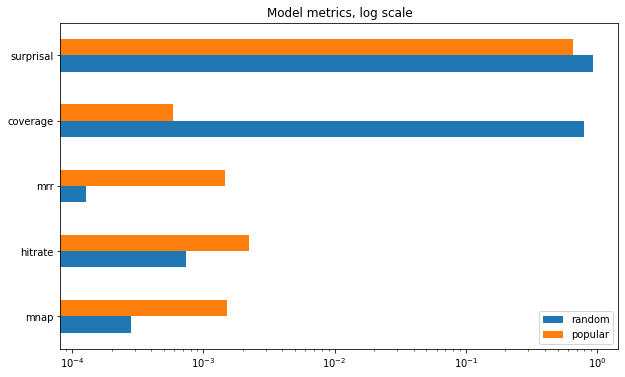

<IPython.core.display.Javascript object>

In [12]:
assessor = Assessor(users, organisations, train_reviews, validation_reviews)
baseline_models = {
    "random": RandomRecommender(users, organisations),
    "popular": PopularRecommender(users, organisations),
}
assessor.assess(baseline_models)
_ = assessor.show_results()

**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выеберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



In [40]:
import implicit

from lightfm.data import Dataset
from scipy.sparse import coo_matrix, csr_matrix
from tqdm.auto import tqdm


class SparseInterface:
    def __init__(self, data):
        self.users = data["users"]
        self.organisations = data["organisations"]
        self.data = data
        self.dataset = Dataset()

    def build(self):
        self.fit()
        self.build_user_features()
        self.build_item_features()
        (
            self.user_id_map,
            self.user_feature_map,
            self.item_id_map,
            self.item_feature_map,
        ) = self.dataset.mapping()
        self.user_id_map = pd.Series(self.user_id_map)
        item_id_map = pd.Series(self.item_id_map)
        self.item_id_map_reverse = pd.Series(item_id_map.index, item_id_map.values)
        self.item_id_map_reverse[0] = 0

    def fit(self):
        self.dataset.fit(
            users=self.users.index,
            items=self.organisations.index,
            user_features=self.users["city"].unique(),
            item_features=list(self.organisations["city"].unique())
            + ["average_bill", "rating"]
            + [f"rubric_{rubric_id}" for rubric_id in self.data["rubrics"].index]
            + [f"feature_{feature_id}" for feature_id in self.data["features"].index],
        )

    def build_user_features(self):
        self.user_features = self.dataset.build_user_features(
            zip(self.users.index, self.users[["city"]].values)
        )

    def build_item_features(self):
        self.item_features = self.dataset.build_item_features(
            (
                (
                    org_id,
                    {
                        **{org_row["city"]: True},
                        **org_row[["average_bill", "rating"]].dropna().to_dict(),
                        **{
                            f"rubric_{rubric_id}": True
                            for rubric_id in org_row["rubrics_id"]
                        },
                        **{
                            f"feature_{feature_id}": True
                            for feature_id in org_row["features_id"]
                        },
                    },
                )
                for org_id, org_row in tqdm(
                    self.organisations.iterrows(),
                    "Building item features",
                    total=len(self.organisations),
                )
            )
        )

    def build_interactions(self, reviews):
        self.interactions, self.interactions_weighted = self.dataset.build_interactions(
            reviews[["user_id", "org_id", "rating"]].dropna().astype("uint64").values
        )

    def user_ids_to_latent(self, user_ids):
        return self.user_id_map.loc[user_ids]

    def recommended_org_ids_from_latent(self, latent_recommendations):
        recommendations = latent_recommendations.apply(
            lambda s: self.item_id_map_reverse.loc[s].values
        )
        return recommendations

<IPython.core.display.Javascript object>

In [14]:
class ImplicitRecommender(BaseRecommender):
    def __init__(self, sparse_interface, model):
        self.model = model
        self.sparse_interface = sparse_interface

    def fit(self, reviews):
        self.sparse_interface.build_interactions(reviews)
        self.interactions = csr_matrix(self.sparse_interface.interactions_weighted)
        self.model.fit(self.interactions)
        return self

    def recommend(self, user_ids, recommend_size=20):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        recommendations, predicted_ratings = self.model.recommend(
            userid=user_ids_mapped,
            user_items=self.interactions[user_ids_mapped],
            filter_already_liked_items=False,
            N=recommend_size,
        )
        recommendations = pd.DataFrame(recommendations, user_ids).replace(-1, 0)
        return self.sparse_interface.recommended_org_ids_from_latent(recommendations)

<IPython.core.display.Javascript object>

In [15]:
sparse_interface = SparseInterface(data)
sparse_interface.build()

Building item features:   0%|          | 0/68339 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [16]:
nn_models = {
    "tfidf": ImplicitRecommender(
        sparse_interface, implicit.nearest_neighbours.TFIDFRecommender()
    ),
    "bm25": ImplicitRecommender(
        sparse_interface, implicit.nearest_neighbours.BM25Recommender()
    ),
    "cosine": ImplicitRecommender(
        sparse_interface, implicit.nearest_neighbours.CosineRecommender()
    ),
}

assessor.assess(nn_models)

/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/nearest_neighbours.py:226: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data**2))[X.row]
/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004187345504760742 seconds
  ParameterWarning,


  0%|          | 0/68339 [00:00<?, ?it/s]

/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002820253372192383 seconds
  ParameterWarning,


  0%|          | 0/68339 [00:00<?, ?it/s]

/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/nearest_neighbours.py:226: RuntimeWarning: invalid value encountered in true_divide
  X.data = X.data / sqrt(bincount(X.row, X.data**2))[X.row]
/external2/dkkoshman/venv/lib/python3.6/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007059812545776367 seconds
  ParameterWarning,


  0%|          | 0/68339 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

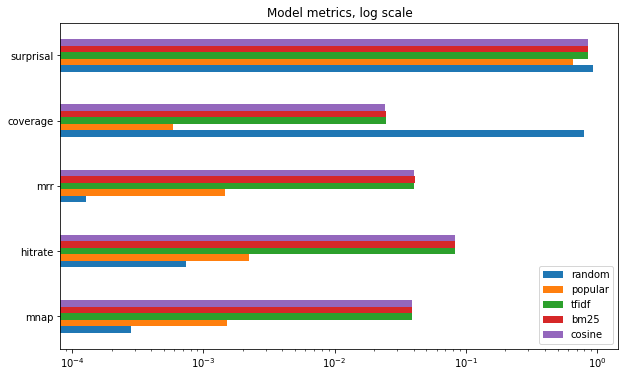

<IPython.core.display.Javascript object>

In [17]:
_ = assessor.show_results()

## Методы Matrix factorization

**(0.5 балла) Задание 6.**

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

Получим представление о том, какие варианты значенией ранга разложения следует попробовать:

In [18]:
from sklearn.decomposition import TruncatedSVD


def plot_component_importance(sparse_interface, n_components=100):
    truncated_svd = TruncatedSVD(n_components=n_components)
    truncated_svd.fit(sparse_interface.interactions_weighted)

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(truncated_svd.explained_variance_ratio_)
    plt.xlabel("n components")
    plt.ylabel("explained variance ratio")
    plt.title("Explained variance depending on number of components")

<IPython.core.display.Javascript object>

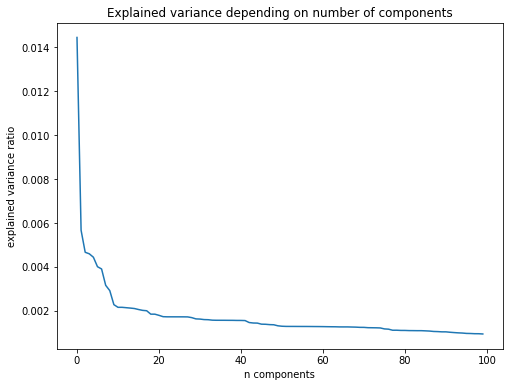

<IPython.core.display.Javascript object>

In [69]:
plot_component_importance(sparse_interface)

In [37]:
class BatchRecommender(ImplicitRecommender):
    def recommend(self, user_ids, recommend_size=20, batch_size=1024):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        interactions = self.interactions[user_ids_mapped]
        recommendations = []

        for begin in range(0, len(user_ids), batch_size):
            batch_slice = slice(begin, begin + batch_size)
            batch_interactions = interactions[batch_slice]
            batch_ids = user_ids[batch_slice]
            batch_ids_mapped = user_ids_mapped[batch_slice]
            batch_rec = self.model_recommend(batch_ids_mapped, batch_interactions)
            batch_rec = np.argpartition(-batch_rec, recommend_size)[:, :recommend_size]
            batch_rec = pd.DataFrame(batch_rec, batch_ids)
            recommendations.append(batch_rec)

        recommendations = self.sparse_interface.recommended_org_ids_from_latent(
            pd.concat(recommendations)
        )
        return recommendations

    @abc.abstractmethod
    def model_recommend(self, user_ids, interactions):
        ...


class SVDRecommender(BatchRecommender):
    def model_recommend(self, user_ids, interactions):
        embedding = self.model.transform(interactions)
        recommendations = self.model.inverse_transform(embedding)
        return recommendations

<IPython.core.display.Javascript object>

In [71]:
matrix_factorization_models = {
    f"svd_{n_components}": SVDRecommender(
        sparse_interface, TruncatedSVD(n_components=n_components)
    )
    for n_components in np.logspace(1, 2, num=2, dtype=int)
}

assessor.assess(matrix_factorization_models)

<IPython.core.display.Javascript object>

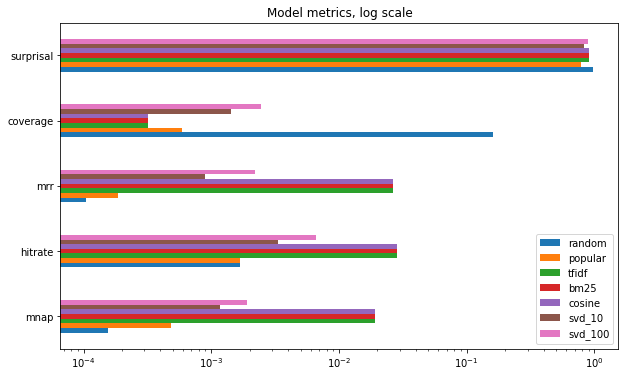

<IPython.core.display.Javascript object>

In [72]:
_ = assessor.show_results()

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

**(1.0 балла) Задание 7.**
Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

In [20]:
from implicit.gpu.als import AlternatingLeastSquares


class ALSFiltered(ImplicitRecommender):
    def __init__(self, *args, filtered_train_reviews, **kwargs):
        super().__init__(*args, **kwargs)
        self.filtered_train_reviews = filtered_train_reviews

    def fit(self, reviews):
        super().fit(self.filtered_train_reviews)

<IPython.core.display.Javascript object>

In [74]:
als_models = {
    "als": ImplicitRecommender(sparse_interface, AlternatingLeastSquares()),
    "als_filtered": ALSFiltered(
        sparse_interface,
        AlternatingLeastSquares(),
        filtered_train_reviews=train_reviews.query("rating >= 4").assign(rating=1),
    ),
}
assessor.assess(als_models)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

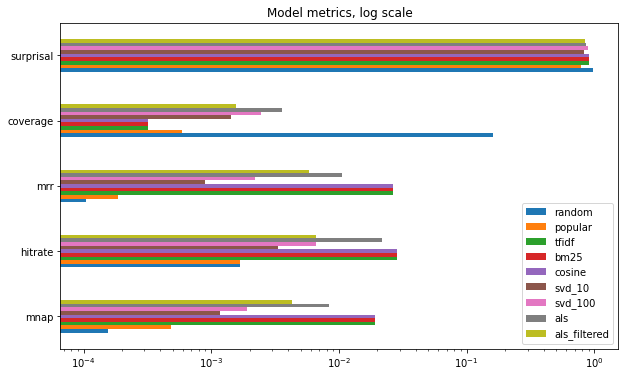

<IPython.core.display.Javascript object>

In [75]:
_ = assessor.show_results()

**(1.0 балла) Задание 8.**

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи. Используя фичи и не используя фичи, сравните результат.

In [68]:
# TODO: add aspects, gridsearch
from lightfm import LightFM


class LightRecommender(BatchRecommender):
    def __init__(self, *args, with_features=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.with_features = with_features

    def fit(self, reviews):
        self.sparse_interface.build_interactions(reviews)
        self.interactions = csr_matrix(self.sparse_interface.interactions_weighted)
        self.model.fit(
            self.interactions,
            user_features=self.sparse_interface.user_features
            if self.with_features
            else None,
            item_features=self.sparse_interface.item_features
            if self.with_features
            else None,
            epochs=10,
            num_threads=8,
            verbose=True,
        )
        return self

    def model_recommend(self, user_ids, interactions):
        user_ids, item_ids = np.meshgrid(
            user_ids, range(len(self.sparse_interface.organisations)), indexing="ij"
        )

        recommendations = self.model.predict(
            user_ids=user_ids.flatten(),
            item_ids=item_ids.flatten(),
            #             user_features=self.sparse_interface.user_features
            #             if self.with_features
            #             else None,
            #             item_features=self.sparse_interface.item_features
            #             if self.with_features
            #             else None,
        ).reshape(user_ids.shape)
        return recommendations

<IPython.core.display.Javascript object>

In [72]:
sparse_interface.item_features

<68339x69364 sparse matrix of type '<class 'numpy.float32'>'
	with 960394 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [36]:
sparse_interface.user_ids_to_latent(1260816866789840047)

865436

<IPython.core.display.Javascript object>

In [49]:
sparse_interface.recommended_org_ids_from_latent(
    pd.DataFrame(
        np.argsort(
            light_models["light"].model.predict(
                user_ids=865436, item_ids=np.arange(len(organisations))
            )
        )
    )
)

,0
0,6309434638950769016
1,6793530981148565425
2,17178946681371600493
3,4153754210897439962
4,6535223947442595824
...,...
68334,11195144987265725249
68335,13400789301905091155
68336,15120040193672648022
68337,16214206783207414400


<IPython.core.display.Javascript object>

In [50]:
sparse_interface.recommended_org_ids_from_latent(
    pd.DataFrame(
        np.argsort(
            light_models["light_no_features"].model.predict(
                user_ids=865436, item_ids=np.arange(len(organisations))
            )
        )
    )
)

,0
0,16556463892627130484
1,3088005150726534921
2,6287988302994539132
3,1113577528751381162
4,17683582560700659966
...,...
68334,3620099101297773783
68335,11006800892303205642
68336,16297918936416443014
68337,6275604663748314015


<IPython.core.display.Javascript object>

In [31]:
train_reviews.query("user_id == 1260816866789840047")

,user_id,org_id,rating,ts,aspects
295580,1260816866789840047,3832428521469619030,4.0,0,NaN


<IPython.core.display.Javascript object>

In [69]:
light_models = {
    "light": LightRecommender(sparse_interface, LightFM()),
    "light_no_features": LightRecommender(
        sparse_interface, LightFM(), with_features=False
    ),
}
assessor.assess(light_models)

Epoch: 100%|██████████| 10/10 [00:00<00:00, 27.47it/s]


<IPython.core.display.Javascript object>

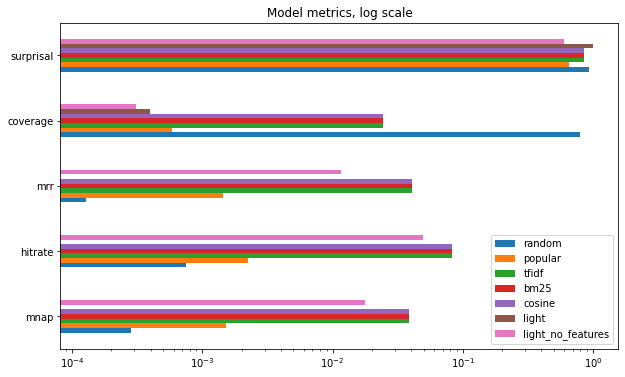

<IPython.core.display.Javascript object>

In [67]:
_ = assessor.show_results()

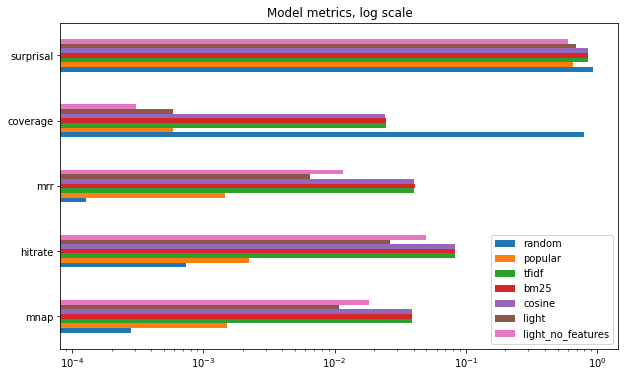

<IPython.core.display.Javascript object>

In [70]:
_ = assessor.show_results()

In [64]:
assessor.assessments["light_no_features"]["recommendations"].loc[49956434489654750]

0      1463651751421197399
1      2096673320182523123
2      3620099101297773783
3     16059287340086436110
4      4186791847928281407
5     11195144987265725249
6     18339206022464148479
7     11006800892303205642
8     16297918936416443014
9     15120040193672648022
10     6275604663748314015
11     8187133161650776223
12     1503331918121917714
13     4477853013398754244
14     3709831741100412687
15     2868785160031411448
16    16214206783207414400
17      336748997849365911
18    17239524486607140551
19    12309025298401950292
Name: 49956434489654750, dtype: uint64

<IPython.core.display.Javascript object>

In [61]:
assessor.assessments["tfidf"]["recommendations"].loc[49956434489654750]

0     15372205785642187831
1      5300695481522514175
2     12064449945454452021
3                        0
4                        0
5                        0
6                        0
7                        0
8                        0
9                        0
10                       0
11                       0
12                       0
13                       0
14                       0
15                       0
16                       0
17                       0
18                       0
19                       0
Name: 49956434489654750, dtype: uint64

<IPython.core.display.Javascript object>

In [63]:
train_reviews.query("user_id == 49956434489654750")

,user_id,org_id,rating,ts,aspects
3958400,49956434489654750,5300695481522514175,5.0,25,6


<IPython.core.display.Javascript object>

In [119]:
len(set(validation_reviews["user_id"]))

600

<IPython.core.display.Javascript object>

In [56]:
set(validation_reviews["user_id"]) & set(train_reviews["user_id"])

{49956434489654750,
 59997744581958185,
 76301336870519302,
 164850595329712755,
 177679379098689591,
 192864739822192175,
 195918093285731171,
 219247439500939836,
 243926358137225995,
 343364370501918204,
 403323615311952453,
 436002081143334355,
 476026990863739896,
 617690061870582216,
 675416695373276789,
 677252960490199146,
 714918200894663566,
 771372888047607944,
 814092367247628589,
 842406622880277358,
 939111408789665529,
 954150073048163992,
 968919213654162680,
 970580849046595712,
 1007080468517852271,
 1079808642651692654,
 1116651621541779916,
 1119830520297470997,
 1205416959973629229,
 1214185174095834743,
 1231639120335999813,
 1263976354353063917,
 1309247615790366060,
 1319530178758826540,
 1347081261599969850,
 1353676387100150977,
 1411505179048283355,
 1486243462664358742,
 1506111569182525708,
 1537896080222081247,
 1543741096010584108,
 1615158209341478841,
 1627568731738334112,
 1655533772790703774,
 1673306185245239712,
 1691818795915119215,
 17238786250211

<IPython.core.display.Javascript object>

In [ ]:
sparse_interface.use

In [129]:
train_reviews.query("user_id == 16649589623140390495")

,user_id,org_id,rating,ts,aspects
562179,16649589623140390495,13704935959835872905,4.0,6,NaN


<IPython.core.display.Javascript object>

In [130]:
assessor.assessments["light_no_features"]["recommendations"].loc[16649589623140390495]

0      4333132988638272316
1     16214206783207414400
2     15120040193672648022
3      2504725748428091362
4     17239524486607140551
5     16297918936416443014
6      2096673320182523123
7      1463651751421197399
8     11006800892303205642
9      6275604663748314015
10     8255436071177180165
11     7244033762487689492
12     7817354760181269529
13    10155146445412626993
14    11195144987265725249
15     4186791847928281407
16      647805440176399974
17     3620099101297773783
18    14286582846726318657
19     3709831741100412687
Name: 16649589623140390495, dtype: uint64

<IPython.core.display.Javascript object>

In [128]:
assessor.assessments["light"]["recommendations"].loc[18400765392363033383]

0     13104037367252018048
1     18432949538634137232
2      6021159400832118532
3      1230524739302283568
4     13339696363435959970
5     11239822096395279608
6      4367430528777363482
7      8092910249760094363
8      4835490095586907229
9     17578923690100197650
10    16204191809361844148
11     4603380641022551772
12    13841868897325631515
13    18088397421874631135
14       90777097076479624
15     4121306388001900879
16    18182676937132029272
17     8283507887285798065
18    13380541298534906181
19    16842956932084109631
Name: 18400765392363033383, dtype: uint64

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 9.**

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформулируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным признаковым описанием будет, например, факт рекомендации данной организации или скор/ранг от моделей SVD, ALS, LightFM.
   Примените catboost/xgboost/lightgbm для создания переранжирования рекомендаций. То есть сделаем двухуровневую модель. Выясните наиболее важные признаки моделей первого уровня.

In [495]:
lightfm_model.predict()

<IPython.core.display.Javascript object>

In [ ]:
list(assessor.assessments.keys())